In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt

import pymc

pd.set_option('display.max_columns', None)
sns.set_palette("Dark2")
sns.set_style("darkgrid")
sns.set_context("paper", font_scale=1.5)

In [9]:
# versions

print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.5.3
numpy==1.24.2
seaborn==0.12.2
arviz==0.15.1
pymc==5.1.2


In [10]:
# import the data prepared in ERF_get_data

df = pd.read_csv('...')

# limit to only taxonomists, and create another df with the full dataset

df2 = df.copy()
df = df.loc[df['taxonomist?'] == 'taxonomist']

len(df)

456

# Variables and categories used for the analysis

In [11]:
demo = ['taxonomist?', 'professional',
       'specialization', 'broad_reader', 'experience', 'species_concepts', 'continent']
agree = ['c1_agree', 'c2_agree','c3_agree']
accept = ['c1_accept','c2_accept','c3_accept']
cases = ['condition_c1','condition_c2','condition_c3']
demo2 = ['taxonomist?','professional','specialization','broad_reader','experience','species_concepts']
lacking = ['c2_lack_morph', 'c2_lack_dna', 'c2_lack_hab','c2_lack_other']

# dictionary for titles
q_dct = {'condition_c1': 'Condition plant case','condition_c2':'Condition frog case','condition_c3':'Condition flatworm case',
        'c1_agree':'Agreement plant case','c2_agree':'Agreement frog case','c3_agree':'Agreement flatworm case'}


# Main outcome: Do you agree?

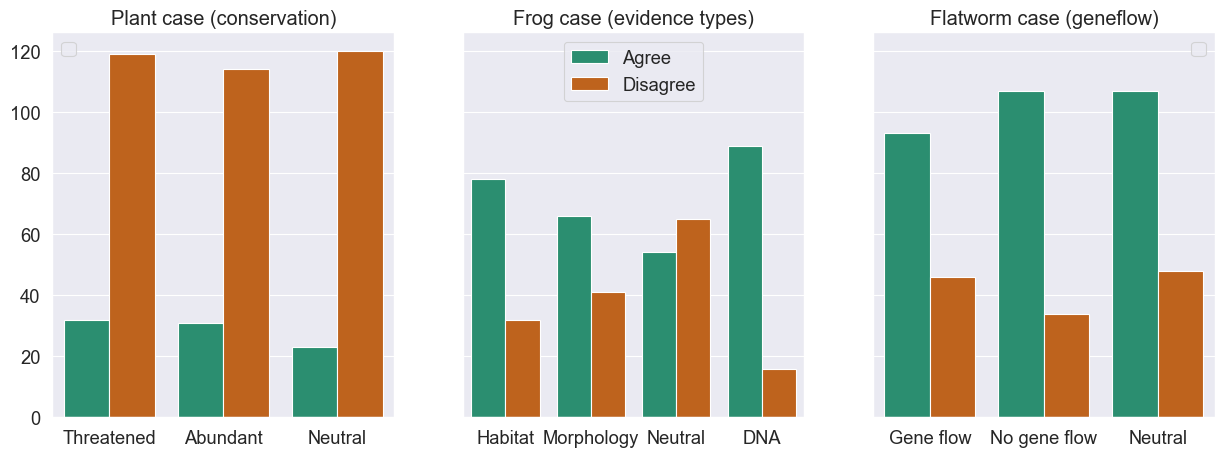

In [12]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,5), sharey = True)

for ax, (i,j) in zip(axs.flat, dict(zip(cases,agree)).items() ):

    sns.countplot(data = df.loc[df[i] != 'No response'], x = i, hue = j, hue_order = ['yes','no'], palette=["C0", "C1"],ax =ax)
    ax.legend('')
    ax.set_xlabel('')
    ax.set_ylabel('')

axs[0].set_title('Plant case (conservation)')

axs[1].set_title('Frog case (evidence types)')
axs[1].legend(['Agree','Disagree'], loc = 'upper center')

axs[2].set_title('Flatworm case (geneflow)')

plt.show()

# Agree & Accept

In [13]:
# counts for all three cases

df[agree+accept].apply(pd.Series.value_counts)

,c1_agree,c2_agree,c3_agree,c1_accept,c2_accept,c3_accept
No response,17,15,21,17,15,21
no,353,154,128,208,98,75
yes,86,287,307,230,337,360


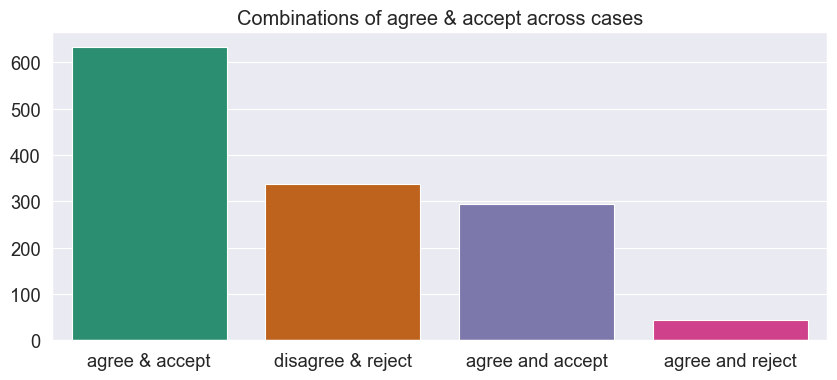

In [14]:
df['c2AgAc'] = (df['c2_agree']) + (df['c2_accept'])
df['c1AgAc'] = (df['c1_agree']) + (df['c1_accept'])
df['c3AgAc'] = (df['c3_agree']) + (df['c3_accept'])


pairsdf = df[['c2AgAc','c1AgAc','c3AgAc']].stack().reset_index()

fig, ax = plt.subplots(figsize = (10,4))


sns.countplot(data = pairsdf.loc[~pairsdf[0].str.contains('No response')],
              x = 0, ax=ax)

ax.set_xticklabels(['agree & accept','disagree & reject','agree and accept','agree and reject'])
ax.set_title('Combinations of agree & accept across cases')
ax.set_xlabel('')
ax.set_ylabel('')

plt.show()             


# Disagreement

We were also interested in how much disagreement there was. For this, we just have to compare the counts of 'yes' and 'no' for the three cases, and look at how big the proportion of the smallest of these is. This is shown below, in general and comparing groups.

In [15]:
# function to calcualte disagreement per case for demographic variables

df[['condition_c1']] = df[['condition_c1']].replace({'Neutral':'Neutral1'} )
df[['condition_c2']] = df[['condition_c2']].replace({'Neutral':'Neutral2'})
df[['condition_c3']] = df[['condition_c3']].replace({'Neutral':'Neutral3'})

dfx = df[cases+agree+demo + ['low_income']]

x = [col for col in df.columns if 'condition' in col]
y = [col for col in df.columns if 'agree' in col]

df3 = pd.lreshape(dfx, {'condition': x,'agree': y})

df3 = df3.astype('category')
df3 = df3.loc[df3.agree != 'No response']

def disagreement_f(demo):
    store1 = {}
    store2 = {}
    
    for i in df3[demo].unique():
        if pd.notnull(i):
            a = df3.loc[df3[demo] == i]
            ct = pd.crosstab(a['agree'], a.condition )
            ct = ct.T
            ct['summed'] = ct.sum(axis = 1)
            ct['agreement'] = np.where(ct.no > ct.yes, ct.yes / ct.summed, ct.no / ct.summed)
            store1[i] = ct.agreement.mean()
            store2[i] = ct
    return (store1,store2)
    

## total

In [16]:
a = df[['c1_agree','condition_c1']].replace({'Neutral':'Neutral1'})
b = df[['c2_agree','condition_c2']].replace({'Neutral':'Neutral2'})
c = df[['c3_agree','condition_c3']].replace({'Neutral':'Neutral3'})

for i in [a,b,c]:
    i.columns = ['agree','condition']

d = pd.concat([a,b,c], axis=0)
d = d.loc[d.condition != 'No response']

In [17]:
ct = pd.crosstab(d['agree'], d.condition )


In [18]:
ct = pd.crosstab(d['agree'], d.condition )
lst = []
for i in range(10):
    
    a = list(ct.iloc[:,i])
    a.sort()
    b = a[0] / sum(a)
    lst.append(b)

disagreement = sum(lst) / 10
print(f'There was {round(disagreement*100, 2)}% disagreement in total')
print('disagreement per condition:')
pd.DataFrame(data = lst, index = ct.columns, columns = ['proportion of disagreement']).T

There was 27.49% disagreement in total
disagreement per condition:


condition,Abundant,DNA,Gene flow,Habitat,Morphology,Neutral1,Neutral2,Neutral3,No gene flow,Threatened
proportion of disagreement,0.213793,0.152381,0.330935,0.290909,0.383178,0.160839,0.453782,0.309677,0.241135,0.211921


## By specialization

<BarContainer object of 14 artists>

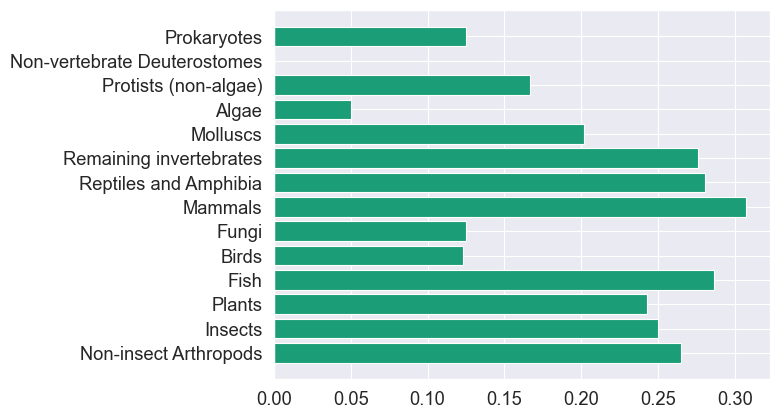

In [19]:
# within group disagreement for specialization groups

dem = 'specialization'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

## By experience

<BarContainer object of 5 artists>

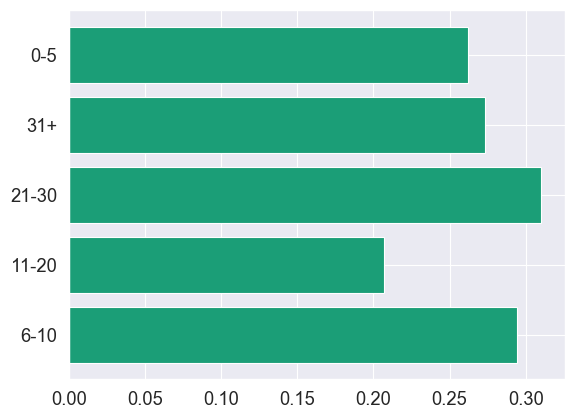

In [20]:
# within group disagreement for experience groups

dem = 'experience'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

## By species concept

<BarContainer object of 6 artists>

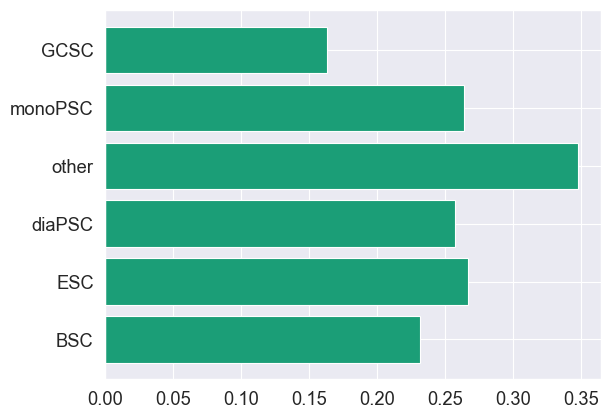

In [21]:
# within group disagreement for species concept groups

dem = 'species_concepts'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

In [22]:
# vizualize within group agreement for the species concept groups for each condition

vals = [pd.DataFrame(disagreement_f('species_concepts')[1][i]).T.loc['agreement'].values for i in df.species_concepts.dropna().unique()]
compare_agr = pd.DataFrame(data = vals, index = df.species_concepts.dropna().unique(), columns = ct.columns )
compare_agr.loc['overall'] = lst
def highlight(s):
    if s.duration > 5:
        return ['background-color: yellow'] * len(s)
    else:
        return ['background-color: white'] * len(s)
    
df.style.apply(highlight, axis=1)

a = compare_agr - compare_agr.iloc[-1]

a.T.iloc[:,:-1].style.background_gradient(axis = None,cmap='seismic').format(precision = 3)

,BSC,ESC,diaPSC,other,monoPSC,GCSC
condition,,,,,,
Abundant,0.080,-0.067,-0.043,0.053,-0.060,-0.214
DNA,-0.057,-0.047,0.010,0.029,0.029,-0.152
Gene flow,-0.081,0.014,0.050,0.078,-0.206,0.002
Habitat,-0.010,-0.051,-0.015,0.084,-0.041,0.109
Morphology,-0.023,0.068,-0.110,0.071,-0.083,0.017
Neutral1,0.006,-0.057,-0.011,0.224,0.006,-0.161
Neutral2,-0.046,0.046,0.001,-0.097,0.008,-0.454
Neutral3,-0.110,-0.041,-0.099,0.024,0.161,0.190
No gene flow,-0.085,0.092,-0.070,0.203,0.053,-0.241


## By professional status

<BarContainer object of 2 artists>

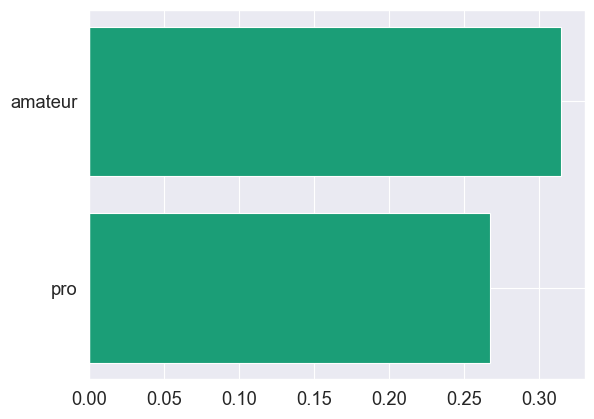

In [23]:
# within group disagreement for professional status groups groups


dem = 'professional'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

## By continent

<BarContainer object of 7 artists>

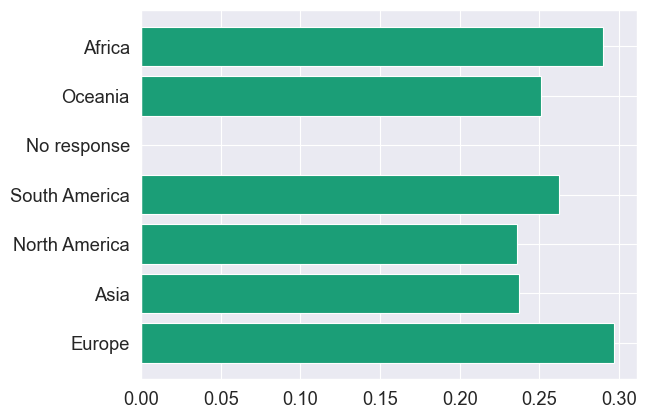

In [24]:
# within group disagreement for continent groups


dem = 'continent'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

## By low income

<BarContainer object of 3 artists>

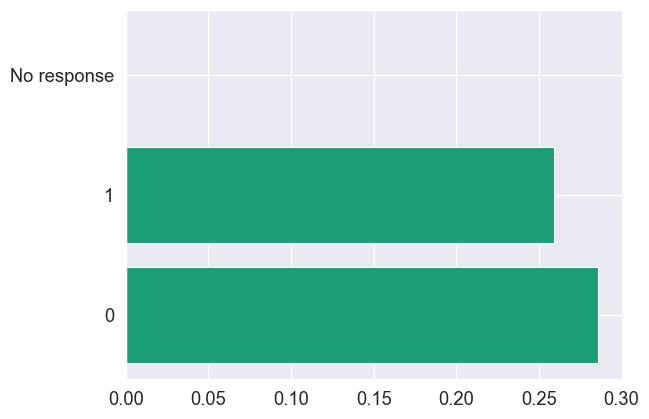

In [25]:
# within group disagreement for income level groups


dem = 'low_income'
plt.barh(list(disagreement_f(dem)[0].keys()), disagreement_f(dem)[0].values() )

## Specialists

In [26]:
# Disagreement in specialist groups for each of the 3 cases

dis2 = df[['c1_agree','c2_agree','c3_agree', 'specialization']]
dis2 = pd.melt(dis2, id_vars = ['specialization'])

dis2 = (dis2.loc[((dis2.specialization == 'Plants') & (dis2.variable == 'c1_agree')) |
                ((dis2.specialization == 'Reptiles and Amphibia') & (dis2.variable == 'c2_agree')) |
                ((dis2.specialization == 'Remaining invertebrates') & (dis2.variable == 'c3_agree'))&
                (dis2.value !='No response')])

ct = pd.crosstab(dis2.value, dis2.variable)

ct


variable,c1_agree,c2_agree,c3_agree
value,,,
No response,1,2,0
no,48,15,10
yes,10,17,33


Disagreement in general was 27.49%, so not different from specialists

In [27]:
lst = []
for i in range(3):
    
    a = list(ct.iloc[:,i])
    a.sort()
    b = a[1] / sum(a)
    lst.append(b)

disagreement = sum(lst) / 3
print(f'There was {round(disagreement*100, 2)}% disagreement among specialists')

There was 28.11% disagreement among specialists


# Splitting and lumping

Because each of our cases asks respondents to split or lump, our survey might also say something about differences between groups in splitting or lumping. The results in the previous section already show this for the three cases separately, here I combine the three cases and compare groups.

In [28]:
sl = df[agree+ demo + ['low_income']]

sl = pd.melt(sl,id_vars=['taxonomist?', 'professional',
      'specialization', 'broad_reader', 'experience',
       'species_concepts', 'continent', 'low_income']) 

## experience

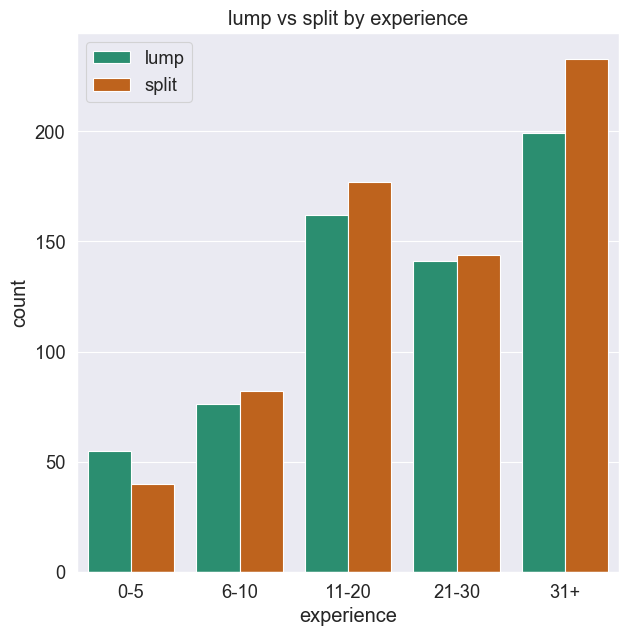

In [29]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,7))

sns.countplot(data = sl.loc[sl.value != 'No response'], order = ['0-5','6-10', '11-20', '21-30', '31+'], x = 'experience', hue = 'value', ax =ax)
ax.set_title('lump vs split by experience')
ax.legend(['lump','split'])

plt.show()

## Geography

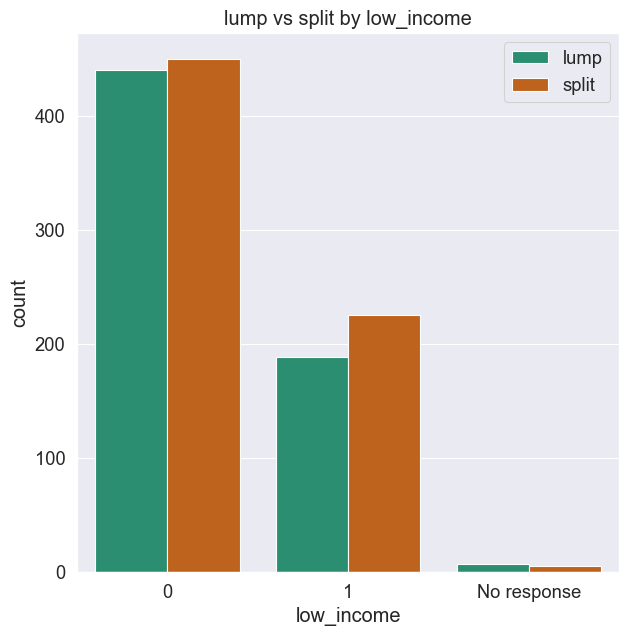

In [30]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,7))

sns.countplot(data = sl.loc[sl.value != 'No response'], x = 'low_income', hue = 'value', ax =ax)
ax.set_title('lump vs split by low_income')
ax.legend(['lump','split'])

plt.show()

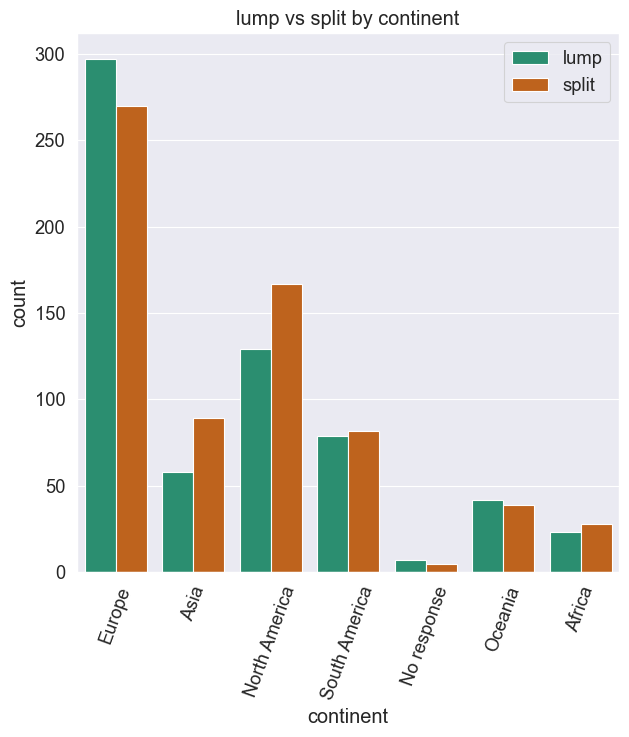

In [31]:
fig, ax = plt.subplots(ncols = 1, figsize = (7,7))

sns.countplot(data = sl.loc[sl.value != 'No response'], x = 'continent', hue = 'value', ax =ax)
ax.set_title('lump vs split by continent')
ax.legend(['lump','split'])
ax.set_xticklabels(sl.continent.unique(),rotation = 70)

plt.show()

## Specialization

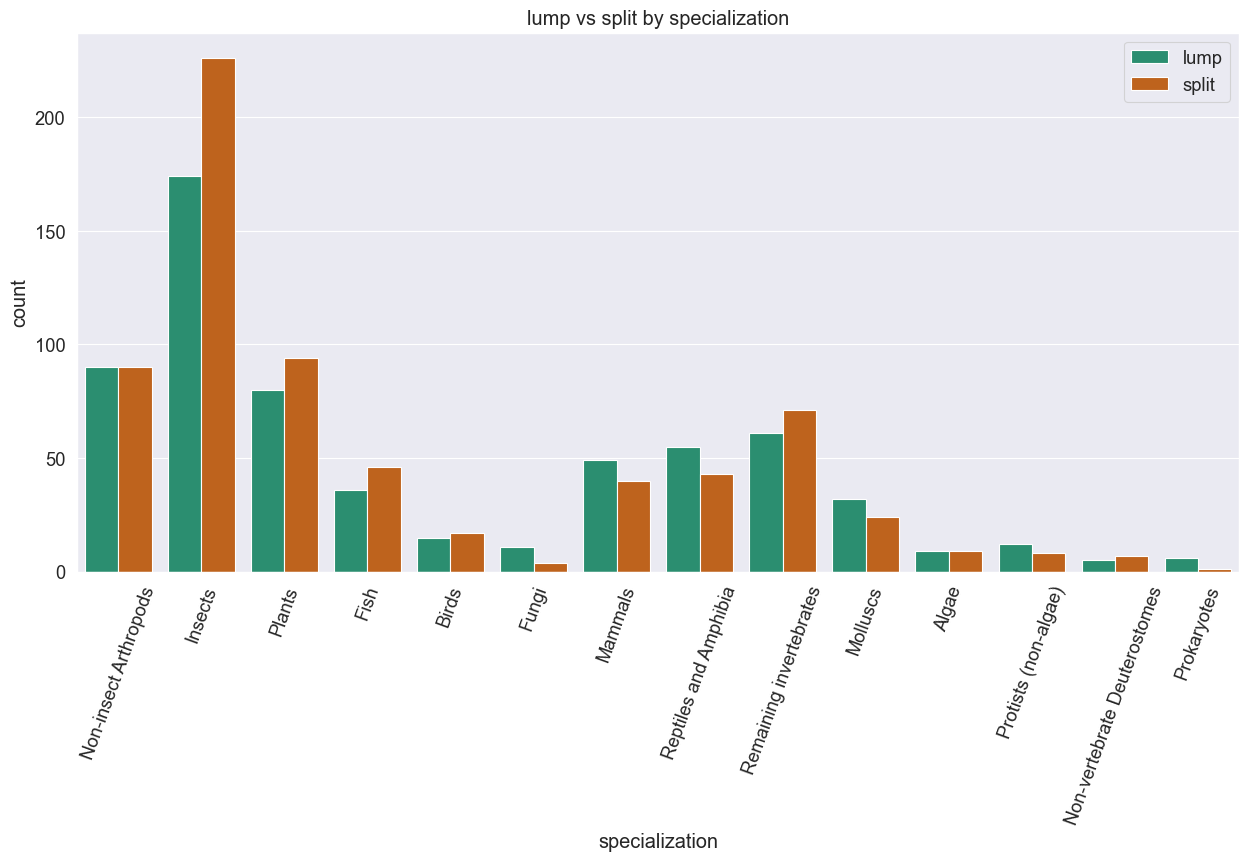

In [32]:
fig, ax = plt.subplots(ncols = 1, figsize = (15,7))

sns.countplot(data = sl.loc[sl.value != 'No response'], x = 'specialization', hue = 'value', ax =ax)
ax.set_title('lump vs split by specialization')
ax.legend(['lump','split'])
ticks = ax.get_xticklabels()
ax.set_xticklabels(ticks,rotation = 70)

plt.show()

## the remaining variables

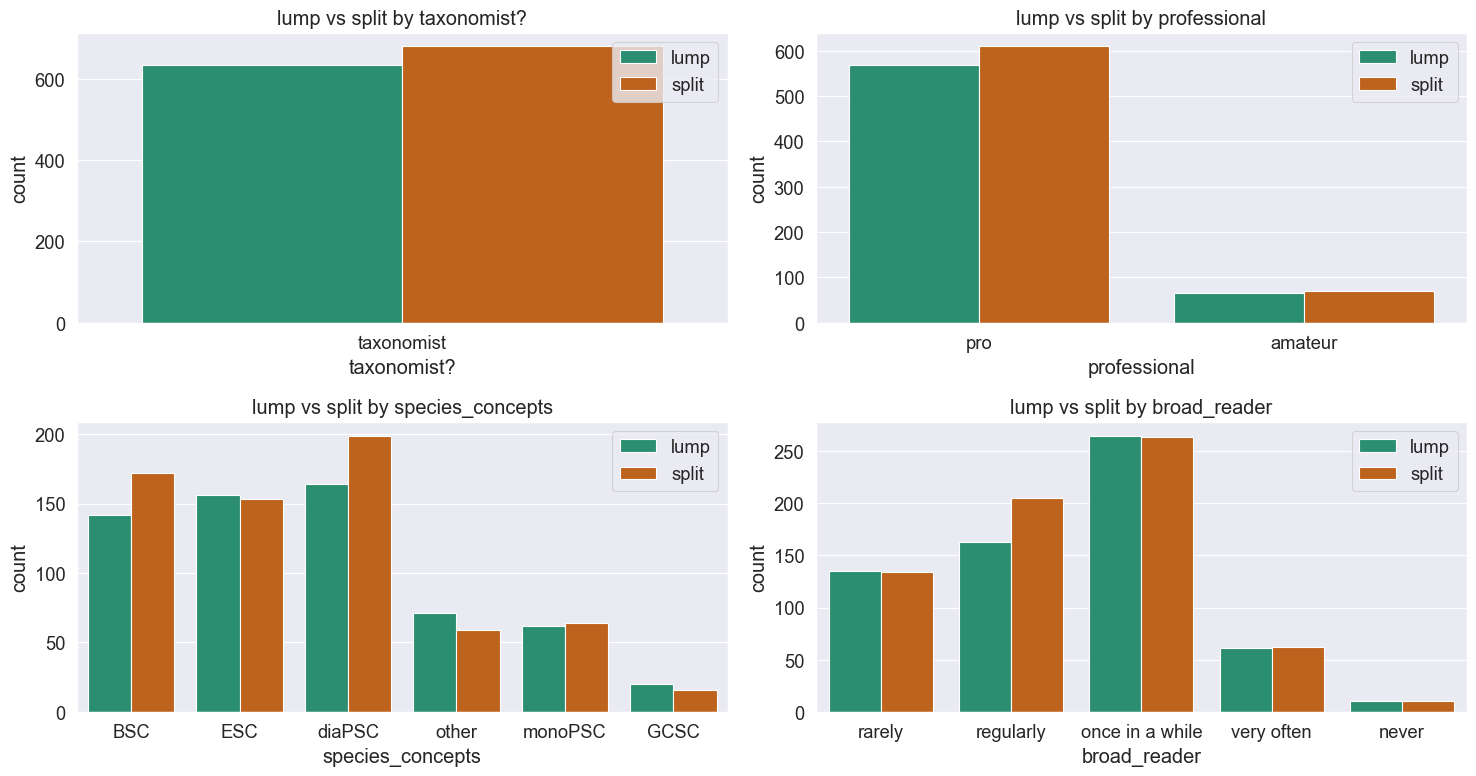

In [33]:
fig, axs = plt.subplots(2,2, figsize = (15,8))


for ax, col in zip(axs.flat, ['taxonomist?','professional','species_concepts','broad_reader']):
    sns.countplot(data = sl.loc[sl.value != 'No response'], x = col, hue = 'value', ax =ax)
    ax.set_title(f'lump vs split by {col}')
    ax.legend(['lump','split'])

    fig.tight_layout()
plt.show()

## Specialists

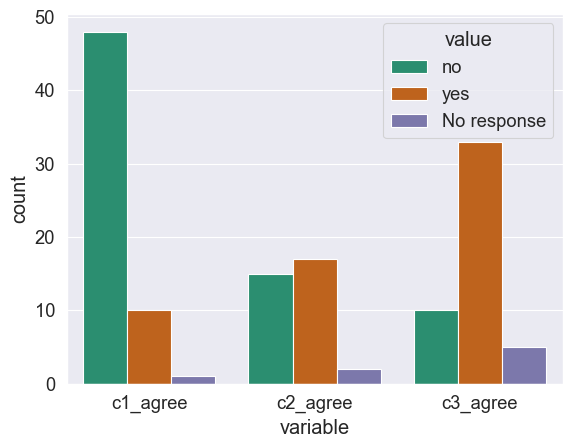

In [34]:
dis2 = df[['c1_agree','c2_agree','c3_agree', 'specialization']]
dis2 = pd.melt(dis2, id_vars = ['specialization'])

dis2 = (dis2.loc[((dis2.specialization == 'Plants') & (dis2.variable == 'c1_agree')) |
                ((dis2.specialization == 'Reptiles and Amphibia') & (dis2.variable == 'c2_agree')) |
                ((dis2.specialization == 'Remaining invertebrates') & (dis2.variable == 'c3_agree'))])

sns.countplot(data = dis2, x = 'variable', hue = 'value')

plt.show()